In [1]:
######### BLOCK 1 #########

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

train = pd.read_excel('data_column_train_matlab.xlsx')
train_data = train.to_numpy()
label = pd.read_excel('data_label_trian_matlab.xlsx')
label_data = label.to_numpy()
final_data = np.concatenate((train_data,label_data),axis =1)

In [2]:
######### BLOCK 2 #########

shuffled_data = np.random.shuffle(final_data)
df = pd.DataFrame(data=final_data)
X_train = final_data[:,0:32]
Y_train = final_data[:,32:]
m = X_train.shape[0]
layer_dims = [32,10,5]
X_train = (X_train-X_train.mean())/X_train.std()

test = pd.read_excel('Test sample set.xlsx')
test1 = test.drop(['fault types'],axis=1)

test2 = test1.drop(['test results'],axis=1)
test3 = test2.to_numpy()
X_test = test3[:,1:]
Y_test = test3[:,0:1]
X_test = (X_test-X_test.mean())/(X_test.std())

m = Y_test.shape[0]
Y_one_hot = np.zeros((m,5))
for i in range(m):
    j = int(Y_test[i])
    Y_one_hot[i,j-1] = Y_one_hot[i,j-1] + 1

test_pred = []
for i in Y_test:
    if i == 1:
        test_pred.append('External Postive-Pole')
    if i == 2:
        test_pred.append('External Negative-Pole')
    if i == 3:
        test_pred.append('Internal Positive-Pole')
    if i == 4:
        test_pred.append('Internal Negative-Pole')
    if i == 5:
        test_pred.append('2 Pole Short Circuit')
        
print(X_train.shape)    

(327, 32)


In [3]:
######### BLOCK 3 #########

def initialize_parameters(layer_dims,optimizer):
    #layer1=32
    #layer2=10
    #layer3=5
    parameters={}
    L = len(layer_dims)
    np.random.seed(1)
    
    if optimizer == 'ADAM':
        for l in range(1,L):
            parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
            parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
            parameters['Vdw'+str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
            parameters['Vdb'+str(l)] = np.zeros((layer_dims[l],1))
            parameters['Sdw'+str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
            parameters['Sdb'+str(l)] = np.zeros((layer_dims[l],1))
            parameters['Vdw_corrected'+str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
            parameters['Vdb_corrected'+str(l)] = np.zeros((layer_dims[l],1))
            parameters['Sdw_corrected'+str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
            parameters['Sdb_corrected'+str(l)] = np.zeros((layer_dims[l],1))
    if optimizer == 'Gradient Descent':
        for l in range(1,L):
            parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
            parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    if optimizer == 'RMSprop':
        for l in range(1,L):
            parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
            parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
            parameters['Vdw'+str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
            parameters['Vdb'+str(l)] = np.zeros((layer_dims[l],1))

        
    return parameters

In [4]:
######### BLOCK 4 #########

# helper function
def relu(x):
    '''
    return np.maximum(0,matrix)
    '''
    # np.where(matrix > 0, matrix, matrix * 0.01)
    y1 = ((x > 0) * x)                                                 
    y2 = ((x <= 0) * x * 0.01)                                         
    leaky_way2 = y1 + y2
    return leaky_way2
    
def sigmoid(matrix):
    return 1/(1+np.exp(-matrix))

def softmax(matrix):
    e_x = np.exp(matrix - np.max(matrix))
    return e_x/e_x.sum(axis=0)

def relu_derivative(x):
    
    x[x<0] = 0.01
    x[x>=0] = 1
    
    return x

def sigmoid_derivative(x):
    df = sigmoid(x)
    return df*(1-df)

In [5]:
######### BLOCK 5 #########
def forward_propogation(parameters,X_train):
    
    cache = {}
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = W1@X_train.T + b1                   #loss func = sigmoid(W2@(relu(W1@X_train.T + b1))+b2)
    A1 = sigmoid(Z1)
    Z2 = W2@A1 + b2
    A2 = softmax(Z2)
    
    #assert(A2.shape == (1, X_train.shape[1]))

    cache = {'Z1':Z1,'A1':A1,'Z2':Z2,'A2':A2}
    return cache


In [6]:
######### BLOCK 6 #########

def compute_cost(lambd,cache,parameters,X_train,Y_train):
    W1 = parameters['W1']
    W2 = parameters['W2']
    A2 = cache['A2']
    m = X_train.shape[0]
     
    cross_entropy = -np.mean(Y_train*np.log(A2.T+np.exp(-8)))
    L2_cost = (np.sum(np.square(W1))+np.sum(np.square(W2))) *np.divide(lambd,2*m)
    cost = cross_entropy + L2_cost
    cost = np.squeeze(cost)
    #assert(isinstance(cost, float))
    return cost


In [7]:
######### BLOCK 7 #########

def backward_propogation(lambd,cache,parameters,Y_train,X_train):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    
    Z1 = cache['Z1']
    A1 = cache['A1']
    Z2 = cache['Z2']
    A2 = cache['A2']
    m = X_train.shape[0]
    gradients = {}
    
    dZ2 = A2 - Y_train.T
    dW2 = (1/m)*dZ2@A1.T+(lambd/m)*W2
    db2 = (1/m)*np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = W2.T@dZ2*sigmoid_derivative(Z1)
    dW1 = (1/m)*dZ1@X_train+(lambd/m)*W1
    db1 = (1/m)*np.sum(dZ1,axis=1,keepdims=True)
    
    gradients = {'dZ2':dZ2,'dW2':dW2,'db2':db2,'dZ1':dZ1,'dW1':dW1,'db1':db1}
    
    return gradients




In [8]:
def optimize(lambd,parameters,gradients,learning_rate,optimizer):#layer_dims
    L = len(layer_dims)
    #Vdw = 0
    #Vdb = 0
    #Sdw = 0
    #Sdb = 0
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 0.00000001
    #L = len(parameters)//2
    
    if optimizer == 'ADAM':
    
        for l in range(L-1):

            parameters['Vdw'+str(l+1)] = beta1*parameters['Vdw'+str(l+1)] +(1-beta1)*gradients['dW'+str(l+1)]
            parameters['Vdb'+str(l+1)] = beta1*parameters['Vdb'+str(l+1)] +(1-beta1)*gradients['db'+str(l+1)]
            parameters['Sdw'+str(l+1)] = beta1*parameters['Sdw'+str(l+1)] +(1-beta2)*(np.square(gradients['dW'+str(l+1)]))
            parameters['Sdb'+str(l+1)] = beta1*parameters['Sdb'+str(l+1)] +(1-beta2)*(np.square(gradients['db'+str(l+1)]))

            parameters['Vdw_corrected'+str(l+1)] = parameters['Vdw'+str(l+1)]/(1-beta1**(l+1))
            parameters['Vdb_corrected'+str(l+1)] = parameters['Vdb'+str(l+1)]/(1-beta1**(l+1))
            parameters['Sdw_corrected'+str(l+1)] = parameters['Sdw'+str(l+1)]/(1-beta2**(l+1))
            parameters['Sdb_corrected'+str(l+1)] = parameters['Sdb'+str(l+1)]/(1-beta2**(l+1))


            parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*parameters['Vdw_corrected'+str(l+1)]/(np.sqrt(parameters['Sdw_corrected'+str(l+1)])+epsilon)  
            parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*parameters['Vdb_corrected'+str(l+1)]/(np.sqrt(parameters['Sdb_corrected'+str(l+1)])+epsilon)
    if optimizer == 'Gradient Descent':
        for l in range(L-1):
            parameters['W'+str(l+1)] = parameters['W'+str(l+1)]*(1-lambd) - learning_rate*gradients['dW'+str(l+1)]
            parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*gradients['db'+str(l+1)]
    
    if optimizer == 'RMSprop':
        for l in range(L-1):
            parameters['Vdw'+str(l+1)] = beta1*parameters['Vdw'+str(l+1)] +(1-beta1)*np.square(gradients['dW'+str(l+1)])
            parameters['Vdb'+str(l+1)] = beta1*parameters['Vdb'+str(l+1)] +(1-beta1)*np.square(gradients['db'+str(l+1)])
            
            parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - (learning_rate*gradients['dW'+str(l+1)])/(np.sqrt(parameters['Vdw'+str(l+1)])+epsilon)
            parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - (learning_rate*gradients['db'+str(l+1)])/(np.sqrt(parameters['Vdb'+str(l+1)])+epsilon)

            
            
    return parameters



In [9]:
def model(X,Y,layer_dims,learning_rate,num_iterations,lambd):
    np.random.seed(1)
    grads = {}
    
    m = X.shape[0]
    opt = ['Gradient Descent','ADAM','RMSprop']
    
    all_costs = {}
    all_parameters = {}
    for optimizer in opt:
        costs = []
        parameters = initialize_parameters(layer_dims,optimizer)

        for i in range(0,num_iterations):

            cache = forward_propogation(parameters,X)
            cost = compute_cost(lambd,cache,parameters,X,Y)
            gradients = backward_propogation(lambd,cache,parameters,Y,X)

            parameters = optimize(lambd,parameters,gradients,learning_rate,optimizer)
            costs.append(cost)
            np.squeeze(cost)
            
            if i%10 == 0:
                print('{} function value after iteration {}: {}'.format(optimizer,i,cost))
        all_costs[optimizer] = costs
        all_parameters[optimizer] = parameters
    return all_parameters,all_costs

In [10]:
final_params,costs = model(X_train,Y_train,layer_dims=[32,10,5],learning_rate=0.0975,num_iterations=5000,lambd=0)

Gradient Descent function value after iteration 0: 0.32114845844476386
Gradient Descent function value after iteration 10: 0.30759970791300245
Gradient Descent function value after iteration 20: 0.30359030749335797
Gradient Descent function value after iteration 30: 0.30213042982892774
Gradient Descent function value after iteration 40: 0.30146248482745736
Gradient Descent function value after iteration 50: 0.3010619293633111
Gradient Descent function value after iteration 60: 0.3007526845284672
Gradient Descent function value after iteration 70: 0.30047013974046527
Gradient Descent function value after iteration 80: 0.3001882693212467
Gradient Descent function value after iteration 90: 0.29989503782286575
Gradient Descent function value after iteration 100: 0.2995835603920488
Gradient Descent function value after iteration 110: 0.2992487728771325
Gradient Descent function value after iteration 120: 0.2988861219961952
Gradient Descent function value after iteration 130: 0.2984910325744

Gradient Descent function value after iteration 1630: 0.09844138736672864
Gradient Descent function value after iteration 1640: 0.09802598200947577
Gradient Descent function value after iteration 1650: 0.09761543667461421
Gradient Descent function value after iteration 1660: 0.09720966445392125
Gradient Descent function value after iteration 1670: 0.09680858039371343
Gradient Descent function value after iteration 1680: 0.09641210144599648
Gradient Descent function value after iteration 1690: 0.09602014642100892
Gradient Descent function value after iteration 1700: 0.09563263594110485
Gradient Descent function value after iteration 1710: 0.0952494923959267
Gradient Descent function value after iteration 1720: 0.09487063989881908
Gradient Descent function value after iteration 1730: 0.09449600424443898
Gradient Descent function value after iteration 1740: 0.0941255128675191
Gradient Descent function value after iteration 1750: 0.09375909480274354
Gradient Descent function value after it

Gradient Descent function value after iteration 2740: 0.07023663147418961
Gradient Descent function value after iteration 2750: 0.07008140529711372
Gradient Descent function value after iteration 2760: 0.06992725161485015
Gradient Descent function value after iteration 2770: 0.06977415976466236
Gradient Descent function value after iteration 2780: 0.06962211923536801
Gradient Descent function value after iteration 2790: 0.06947111966440603
Gradient Descent function value after iteration 2800: 0.06932115083497269
Gradient Descent function value after iteration 2810: 0.06917220267322563
Gradient Descent function value after iteration 2820: 0.06902426524555313
Gradient Descent function value after iteration 2830: 0.06887732875590766
Gradient Descent function value after iteration 2840: 0.06873138354320137
Gradient Descent function value after iteration 2850: 0.06858642007876214
Gradient Descent function value after iteration 2860: 0.06844242896384875
Gradient Descent function value after 

Gradient Descent function value after iteration 4350: 0.05433274624592491
Gradient Descent function value after iteration 4360: 0.05427134378022243
Gradient Descent function value after iteration 4370: 0.05421023872830026
Gradient Descent function value after iteration 4380: 0.05414942907887073
Gradient Descent function value after iteration 4390: 0.05408891283721219
Gradient Descent function value after iteration 4400: 0.054028688025016716
Gradient Descent function value after iteration 4410: 0.053968752680239346
Gradient Descent function value after iteration 4420: 0.05390910485694924
Gradient Descent function value after iteration 4430: 0.05384974262518226
Gradient Descent function value after iteration 4440: 0.05379066407079538
Gradient Descent function value after iteration 4450: 0.053731867295322554
Gradient Descent function value after iteration 4460: 0.0536733504158323
Gradient Descent function value after iteration 4470: 0.053615111564786606
Gradient Descent function value aft

ADAM function value after iteration 740: 0.0003707956024805649
ADAM function value after iteration 750: -1.8383977113063658e-05
ADAM function value after iteration 760: -4.266408610110723e-05
ADAM function value after iteration 770: -6.408916991937287e-05
ADAM function value after iteration 780: -6.486212576151592e-05
ADAM function value after iteration 790: -6.464656258865561e-05
ADAM function value after iteration 800: -6.574746672664311e-05
ADAM function value after iteration 810: -6.518925676715382e-05
ADAM function value after iteration 820: -6.569634829943983e-05
ADAM function value after iteration 830: -6.578994583276067e-05
ADAM function value after iteration 840: -6.598136246718946e-05
ADAM function value after iteration 850: -6.604660161431046e-05
ADAM function value after iteration 860: -6.61362066505768e-05
ADAM function value after iteration 870: -6.624182515521096e-05
ADAM function value after iteration 880: -6.636768863748727e-05
ADAM function value after iteration 890: 

ADAM function value after iteration 2040: -6.675577605292461e-05
ADAM function value after iteration 2050: -6.680932991293051e-05
ADAM function value after iteration 2060: -6.703188551357172e-05
ADAM function value after iteration 2070: -6.707099070844408e-05
ADAM function value after iteration 2080: -6.707723313243021e-05
ADAM function value after iteration 2090: -6.707859793222264e-05
ADAM function value after iteration 2100: -6.707900184547748e-05
ADAM function value after iteration 2110: -6.707929630091958e-05
ADAM function value after iteration 2120: -6.707961681661631e-05
ADAM function value after iteration 2130: -6.7079833353702e-05
ADAM function value after iteration 2140: -6.707992493170824e-05
ADAM function value after iteration 2150: -6.708002119084278e-05
ADAM function value after iteration 2160: -6.70800910839976e-05
ADAM function value after iteration 2170: -6.708014145286921e-05
ADAM function value after iteration 2180: -6.708016855221693e-05
ADAM function value after it

ADAM function value after iteration 3720: -6.708125024391065e-05
ADAM function value after iteration 3730: -6.708125042266233e-05
ADAM function value after iteration 3740: -6.708125059859615e-05
ADAM function value after iteration 3750: -6.708125077177793e-05
ADAM function value after iteration 3760: -6.708125094227829e-05
ADAM function value after iteration 3770: -6.708125111015423e-05
ADAM function value after iteration 3780: -6.708125127547406e-05
ADAM function value after iteration 3790: -6.708125143829276e-05
ADAM function value after iteration 3800: -6.70812515986706e-05
ADAM function value after iteration 3810: -6.708125175666012e-05
ADAM function value after iteration 3820: -6.70812519123212e-05
ADAM function value after iteration 3830: -6.708125206569959e-05
ADAM function value after iteration 3840: -6.708125221685229e-05
ADAM function value after iteration 3850: -6.70812523658267e-05
ADAM function value after iteration 3860: -6.708125251266939e-05
ADAM function value after it

RMSprop function value after iteration 140: 0.03314696536124719
RMSprop function value after iteration 150: 0.03268379867251218
RMSprop function value after iteration 160: 0.03214191444553377
RMSprop function value after iteration 170: 0.03170076569368788
RMSprop function value after iteration 180: 0.03133243916836663
RMSprop function value after iteration 190: 0.031009610227746072
RMSprop function value after iteration 200: 0.0296009086431273
RMSprop function value after iteration 210: 0.030603831669276046
RMSprop function value after iteration 220: 0.030418726932086103
RMSprop function value after iteration 230: 0.02996986063624268
RMSprop function value after iteration 240: 0.02973132737971318
RMSprop function value after iteration 250: 0.0295312268205135
RMSprop function value after iteration 260: 0.029346825008709984
RMSprop function value after iteration 270: 0.02916048767467026
RMSprop function value after iteration 280: 0.028411666388258584
RMSprop function value after iteratio

RMSprop function value after iteration 1710: 0.00034674781207774994
RMSprop function value after iteration 1720: 0.00030261824460509377
RMSprop function value after iteration 1730: 0.00027417739893391017
RMSprop function value after iteration 1740: 0.0002504866644391765
RMSprop function value after iteration 1750: 0.005040345897963123
RMSprop function value after iteration 1760: 0.0002647490595255737
RMSprop function value after iteration 1770: 0.0002450437071718688
RMSprop function value after iteration 1780: 0.00023237860816698096
RMSprop function value after iteration 1790: 0.00021939504780209783
RMSprop function value after iteration 1800: 0.00020359561116191434
RMSprop function value after iteration 1810: 0.00018348945801106528
RMSprop function value after iteration 1820: 0.00019289821672344772
RMSprop function value after iteration 1830: 0.00017937048068063902
RMSprop function value after iteration 1840: 0.00017041154223399886
RMSprop function value after iteration 1850: 0.000162

RMSprop function value after iteration 3280: -4.4954768305851615e-05
RMSprop function value after iteration 3290: -4.7176153429950043e-05
RMSprop function value after iteration 3300: -4.918959446104622e-05
RMSprop function value after iteration 3310: -2.361027265022023e-05
RMSprop function value after iteration 3320: -3.84560829955493e-05
RMSprop function value after iteration 3330: -4.2494373726666384e-05
RMSprop function value after iteration 3340: -4.432954868511925e-05
RMSprop function value after iteration 3350: -4.57527763482463e-05
RMSprop function value after iteration 3360: -4.704455713150391e-05
RMSprop function value after iteration 3370: -4.8248663661203876e-05
RMSprop function value after iteration 3380: -4.937147231497569e-05
RMSprop function value after iteration 3390: -5.043976999477505e-05
RMSprop function value after iteration 3400: -5.151667759004966e-05
RMSprop function value after iteration 3410: -8.287737626579056e-06
RMSprop function value after iteration 3420: 1

RMSprop function value after iteration 4810: -6.357588825141644e-05
RMSprop function value after iteration 4820: -6.36415342198038e-05
RMSprop function value after iteration 4830: -6.3728726813543e-05
RMSprop function value after iteration 4840: -6.384975602110293e-05
RMSprop function value after iteration 4850: -6.401422995060593e-05
RMSprop function value after iteration 4860: -5.905196707502377e-05
RMSprop function value after iteration 4870: -3.3240801767687215e-05
RMSprop function value after iteration 4880: -4.698479206811443e-05
RMSprop function value after iteration 4890: -5.3839708095600246e-05
RMSprop function value after iteration 4900: -5.793068409487056e-05
RMSprop function value after iteration 4910: -6.040946666349609e-05
RMSprop function value after iteration 4920: -6.184264261035177e-05
RMSprop function value after iteration 4930: -6.2677382864775e-05
RMSprop function value after iteration 4940: -6.322842469801125e-05
RMSprop function value after iteration 4950: -6.362

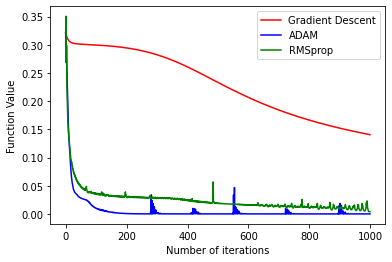

In [11]:
plt.plot(list(range(1000)),costs['Gradient Descent'][:1000],'-r')
plt.plot(list(range(1000)),costs['ADAM'][:1000],'-b')
plt.plot(list(range(1000)),costs['RMSprop'][:1000],'-g')
plt.ylabel('Function Value')
plt.xlabel('Number of iterations')
plt.legend(['Gradient Descent','ADAM','RMSprop'])
plt.show()

In [17]:
def predict_2(params,X,Y):
    all_y_pred={}
    accu={}
    for l in list(params.keys()):
        cache = forward_propogation(params[l],X)
        A2 = cache['A2']
        pred_one_hot = np.zeros(A2.T.shape)
        y_pred=[]
        for i in range(A2.T.shape[0]):
            max_value = np.argmax(A2.T[i])
            pred_one_hot[i,max_value] = 1
            if max_value == 0:
                y_pred.append('External Postive-Pole')
            if max_value == 1:
                y_pred.append('External Negative-Pole')
            if max_value == 2:
                y_pred.append('Internal Positive-Pole')
            if max_value == 3:
                y_pred.append('Internal Negative-Pole')
            if max_value == 4:
                y_pred.append('2 Pole Short Circuit')
        
        all_y_pred[l] = y_pred
        correct = 0
        wrong = 0
        
        for i in range(A2.T.shape[0]):
            if (pred_one_hot[i] == Y_one_hot[i]).all():
                print('{} Correct prediction for sample {}'.format(l,i))
                correct +=1
            else:
                print('{} Wrong prediction for sample {}'.format(l,i))
                wrong += 1
        accu[l] = correct/(correct+wrong) * 100

    return accu,all_y_pred

In [18]:
accuracy,predictions= predict_2(final_params,X_test,Y_one_hot)

Gradient Descent Correct prediction for sample 0
Gradient Descent Correct prediction for sample 1
Gradient Descent Correct prediction for sample 2
Gradient Descent Correct prediction for sample 3
Gradient Descent Correct prediction for sample 4
Gradient Descent Correct prediction for sample 5
Gradient Descent Correct prediction for sample 6
Gradient Descent Correct prediction for sample 7
Gradient Descent Correct prediction for sample 8
Gradient Descent Correct prediction for sample 9
Gradient Descent Correct prediction for sample 10
Gradient Descent Correct prediction for sample 11
Gradient Descent Correct prediction for sample 12
Gradient Descent Correct prediction for sample 13
Gradient Descent Correct prediction for sample 14
Gradient Descent Correct prediction for sample 15
Gradient Descent Correct prediction for sample 16
Gradient Descent Correct prediction for sample 17
Gradient Descent Correct prediction for sample 18
Gradient Descent Correct prediction for sample 19
Gradient D

In [19]:
accuracy

{'Gradient Descent': 79.34782608695652,
 'ADAM': 81.52173913043478,
 'RMSprop': 76.08695652173914}

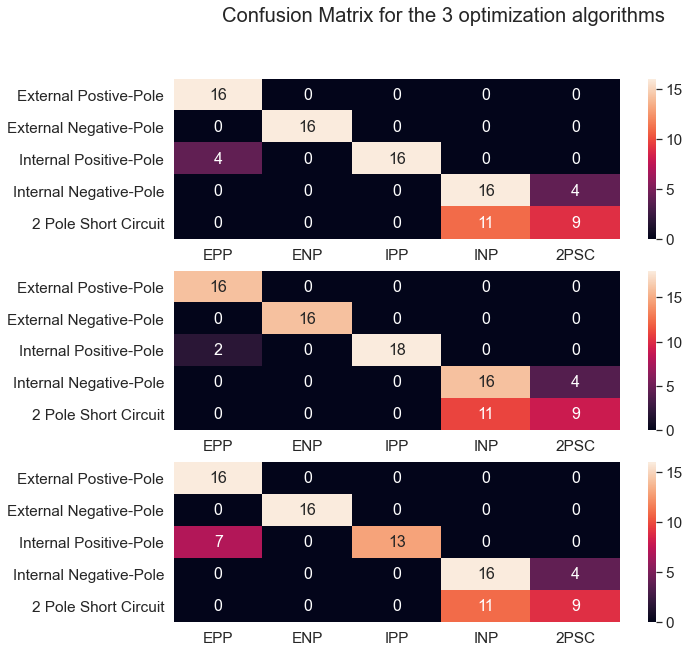

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
cm={}
for k in predictions.keys():

    cm[k] = confusion_matrix(test_pred,predictions[k],labels=['External Postive-Pole','External Negative-Pole',
                                                           'Internal Positive-Pole','Internal Negative-Pole',
                                                           '2 Pole Short Circuit'])
    
#plt.figure(figsize=(20,15))
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
fig.suptitle('Confusion Matrix for the 3 optimization algorithms')

sns.set(font_scale=1.4)

df_cm1 = pd.DataFrame(cm['Gradient Descent'],['External Postive-Pole','External Negative-Pole','Internal Positive-Pole',
                                              'Internal Negative-Pole','2 Pole Short Circuit'],['EPP','ENP','IPP','INP','2PSC'])
sns.heatmap(df_cm1,ax=ax1,annot=True,annot_kws={"size":16})
df_cm2 = pd.DataFrame(cm['ADAM'],['External Postive-Pole','External Negative-Pole','Internal Positive-Pole',
                                  'Internal Negative-Pole','2 Pole Short Circuit'],['EPP','ENP','IPP','INP','2PSC'])
sns.heatmap(df_cm2,ax=ax2,annot=True,annot_kws={"size":16})
df_cm3 = pd.DataFrame(cm['RMSprop'],['External Postive-Pole','External Negative-Pole','Internal Positive-Pole',
                                     'Internal Negative-Pole','2 Pole Short Circuit'],['EPP','ENP','IPP','INP','2PSC'])
sns.heatmap(df_cm3,ax=ax3,annot=True,annot_kws={"size":16})
    
plt.show()